In [2]:
import pandas as pd
from datasets import Dataset
from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import os
import re
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Check current GPU memory usage
import torch
torch.cuda.memory_summary()

# For a simpler view of allocated memory
print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
print(f"Cached: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")

Allocated: 0.00 MB
Cached: 0.00 MB


In [4]:
csv_file = "mimic_cxr.csv"  # Replace with your actual file name
images_folders = ["./images_NEW", "./images_NEW_2", "./images_NEW_3", "./images_NEW_4"]  

# Load the CSV into a DataFrame
df = pd.read_csv(csv_file)

# Create a list of all image IDs from the image folders
image_files = []
for folder in images_folders:
    image_files.extend([f for f in os.listdir(folder) if f.endswith(".jpg")])
image_ids = [os.path.splitext(f)[0] for f in image_files]

# Counters for images with and without an assigned row
unmatched_images_count = 0
matched_images_count = 0

# Add image path column to the DataFrame
def get_image_path(dicom_id):
    dicom_id_no_ext = dicom_id.replace(".jpg", "")
    global matched_images_count, unmatched_images_count
    for folder in images_folders:
        image_path = os.path.join(folder, dicom_id_no_ext + ".jpg")
        if dicom_id_no_ext in image_ids and os.path.exists(image_path):
            matched_images_count += 1
            return image_path
    return None

df["image_path"] = df["dicom_id"].apply(get_image_path)


print(len(image_files))
# Print confirmation
print("Image paths have been added and saved to mimic_csv_with_paths.csv")
print(f"Number of images with an assigned row: {matched_images_count}")
df = df[df["image_path"].notna()]



4578
Image paths have been added and saved to mimic_csv_with_paths.csv
Number of images with an assigned row: 4578


In [5]:
df.head()

,study_id_x,ordering_provider_id,attending_provider_id,resident_provider_id,subject_id_original,dicom_id,path_x,subject_id_y,path_y,subject_id_x,...,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,Content,image_path
35,55979577,P38GSR,P374WB,NaN,14533062,0006a816-5140e307-815c7b9f-4856cbc6-670b7e6d.jpg,0006a816-5140e307-815c7b9f-4856cbc6-670b7e6d.dcm,14533062,s55979577.txt,14533062.0,...,PA,2022,2022,21180531,100918.000,CHEST (PA AND LAT),postero-anterior,Erect,FINAL REPORT\...,./images_NEW/0006a816-5140e307-815c7b9f-4856cb...
149,55719848,P36CPU,P86AVY,P64YX0,14277220,001aab77-00f58710-2f7d060b-33213f2d-dccb8daf.jpg,001aab77-00f58710-2f7d060b-33213f2d-dccb8daf.dcm,14277220,s55719848.txt,14277220.0,...,PA,3056,2544,21311030,100718.218,CHEST (PA AND LAT),postero-anterior,Erect,FINAL REPORT\...,./images_NEW/001aab77-00f58710-2f7d060b-33213f...
156,51003101,P78HFS,P10LBA,P49LB9,11014367,001be345-4a6bfea6-69ade6d8-8d972d00-1c9ed5cf.jpg,001be345-4a6bfea6-69ade6d8-8d972d00-1c9ed5cf.dcm,11014367,s51003101.txt,11014367.0,...,PA,2021,2021,21950619,151540.000,CHEST (PA AND LAT),postero-anterior,Recumbent,FINAL REPORT\...,./images_NEW_3/001be345-4a6bfea6-69ade6d8-8d97...
289,54629076,P83K6F,P26C49,P6484U,13584591,0031238b-59d3c74e-c91468b6-fbba47b9-7c10998c.jpg,0031238b-59d3c74e-c91468b6-fbba47b9-7c10998c.dcm,13584591,s54629076.txt,13584591.0,...,PA,2544,3056,21240615,145701.265,CHEST (PA AND LAT),postero-anterior,Erect,FINAL REPORT\...,./images_NEW_2/0031238b-59d3c74e-c91468b6-fbba...
408,54396441,P91AKE,P374WB,NaN,11079199,00454f0b-2d77b234-618b06da-e2d47e1c-08275286.jpg,00454f0b-2d77b234-618b06da-e2d47e1c-08275286.dcm,11079199,s54396441.txt,11079199.0,...,PA,2021,1796,21141117,133337.000,CHEST (PA AND LAT),postero-anterior,Recumbent,FINAL REPORT\...,./images_NEW_3/00454f0b-2d77b234-618b06da-e2d4...


In [6]:
def clean_radiology_text(text):
    """
    Clean radiology report text by:
    1. Removing notification section
    2. Removing extra whitespace and paragraph breaks
    3. Removing underscores
    """
    # Handle NaN or None values
    if pd.isna(text):
        return text
        
    # First remove notification section if it exists
    if "NOTIFICATION:" in str(text):
        text = text.split("NOTIFICATION:")[0]
    
    # Remove underscores (single or multiple)
    text = text.replace('___', '')
    text = text.replace('__', '')
    text = text.replace('_', '')
    
    # Remove extra whitespace and newlines
    cleaned_text = ' '.join(str(text).split())
    
    return cleaned_text.strip()


def combine_sections(text):
    # Split into findings and impression sections
    findings = ""
    if "FINDINGS:" in text:
        findings = ' '.join(text.split("FINDINGS:")[1:]).split("IMPRESSION:")[0].strip()
    
    impression = ""
    if "IMPRESSION:" in text:
        impression = ' '.join(text.split("IMPRESSION:")[1:]).strip()
    
    return f"{findings} {impression}".strip()




df = df[df["Content"].notna()]
df['Content'] = df['Content'].apply(clean_radiology_text)
df["Content"] = df["Content"].apply(combine_sections)
df = df[["image_path", "Content"]]

In [37]:
def find_cells_in_word_range(df, min_count, max_count, column_name="Content"):
    """
    Print all cells that have a word count within the specified range.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to search
    min_count (int): The minimum number of words
    max_count (int): The maximum number of words
    column_name (str): Name of the column to search in (defaults to "Content")
    """
    # Function to count words in a cell
    def count_words(text):
        if pd.isna(text):  # Handle NaN values
            return 0
        return len(str(text).split())
    
    # Get word counts for all cells
    word_counts = df[column_name].apply(count_words)
    
    # Find rows within the word count range
    matches = df[(word_counts >= min_count) & (word_counts <= max_count)]
    
    # Count total cells meeting the criteria
    total_matching = len(matches)
    
    print(f"Statistics for cells with {min_count} to {max_count} words:")
    print(f"Total matching cells: {total_matching}")
    print(f"Percentage of dataset: {(total_matching / len(df) * 100):.2f}%")
    print("-" * 80)
    
    # Print each matching cell with its index and word count
    for idx, content in matches[column_name].items():
        print(f"\nIndex {idx} ({count_words(content)} words):")
        print(content)
        print("-" * 80)

find_cells_in_word_range(df, 20, 60)  # Find all cells with 50-100 words

Statistics for cells with 20 to 60 words:
Total matching cells: 3122
Percentage of dataset: 68.20%
--------------------------------------------------------------------------------

Index 149 (49 words):
Bilateral hazy opacities interstitial are visualized and likely representative of fibrotic changes. Otherwise the lungs are without a focal consolidation, effusion, or pneumothorax. Cardiomediastinal silhouette is within normal limits. No acute fractures are identified. No evidence of acute injury. Bilateral hazy interstitial opacities are likely representative of fibrotic changes.
--------------------------------------------------------------------------------

Index 156 (28 words):
Cardiomediastinal silhouette stable. Left internal jugular central venous catheter in stable position. Right basilar opacity has improved. There is no pleural effusion or pneumothorax. Improved right basilar consolidation.
--------------------------------------------------------------------------------

Ind

In [38]:
def filter_df_by_word_range(df, min_words=20, max_words=60, grace_words=5, column_name="Content"):
    """
    Filter DataFrame to include texts within word range, with grace words for sentence completion.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    min_words (int): Minimum word count (default: 20)
    max_words (int): Maximum word count (default: 60)
    grace_words (int): Additional words allowed to complete sentences (default: 5)
    column_name (str): Column to analyze (default: "Content")
    
    Returns:
    pandas.DataFrame: Filtered DataFrame
    """
    def count_words(text):
        if pd.isna(text):
            return 0
        return len(str(text).split())
    
    # Get word counts
    word_counts = df[column_name].apply(count_words)
    
    # Create mask for filtering
    mask = (word_counts >= min_words) & (word_counts <= (max_words + grace_words))
    filtered_df = df[mask].copy()
    
    # Print statistics
    total_before = len(df)
    total_after = len(filtered_df)
    
    print(f"Original DataFrame size: {total_before}")
    print(f"Filtered DataFrame size: {total_after}")
    print(f"Removed {total_before - total_after} rows")
    print(f"Kept {(total_after/total_before * 100):.2f}% of original data")
    
    return filtered_df

filtered_df = filter_df_by_word_range(df)

Original DataFrame size: 4578
Filtered DataFrame size: 3321
Removed 1257 rows
Kept 72.54% of original data



Overall Statistics:
Average number of sentences per cell: 5.86
Average sentence length (words): 7.70

Detailed Statistics:
       num_sentences  avg_sentence_length
count    4578.000000          4578.000000
mean        5.856269             7.704038
std         2.864404             3.117599
min         0.000000             0.000000
25%         4.000000             6.000000
50%         6.000000             7.142857
75%         7.000000             9.000000
max        59.000000            33.000000


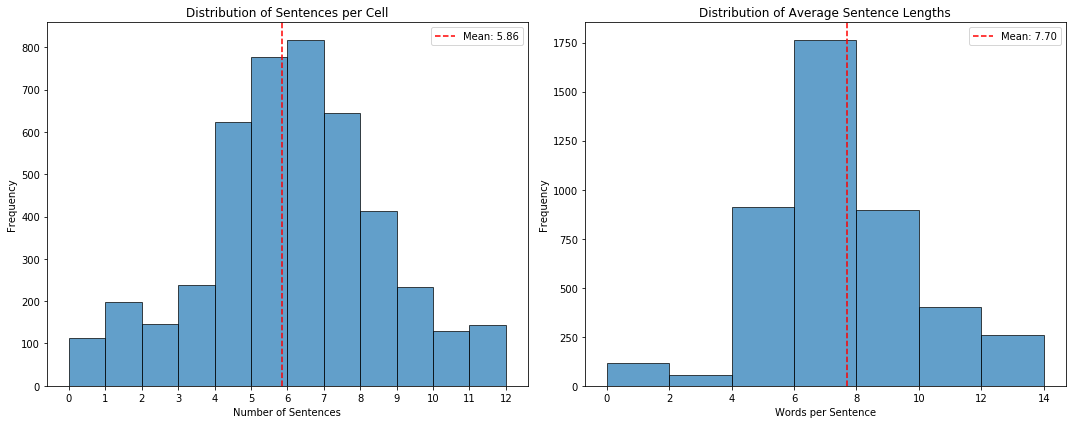

In [39]:
def analyze_sentence_statistics(df, text_column='Content'):
    """
    Analyze sentence statistics for each cell with appropriate bin ranges
    """
    def get_cell_stats(text):
        sentences = re.split(r'[.!?]+(?=\s|$)', text.strip())
        sentences = [s.strip() for s in sentences if s.strip()]
        
        num_sentences = len(sentences)
        words_per_sentence = [len(re.findall(r'\b\w+\b', sentence)) for sentence in sentences]
        avg_length = sum(words_per_sentence) / num_sentences if num_sentences > 0 else 0
        
        return pd.Series({
            'num_sentences': num_sentences,
            'avg_sentence_length': avg_length
        })

    stats = df[text_column].apply(get_cell_stats)
    
    print("\nOverall Statistics:")
    print(f"Average number of sentences per cell: {stats['num_sentences'].mean():.2f}")
    print(f"Average sentence length (words): {stats['avg_sentence_length'].mean():.2f}")
    print("\nDetailed Statistics:")
    print(stats.describe())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Determine appropriate bin ranges based on data
    max_sentences = int(np.ceil(stats['num_sentences'].quantile(0.95)))  # Use 95th percentile
    max_length = int(np.ceil(stats['avg_sentence_length'].quantile(0.95)))  # Use 95th percentile
    
    # Plot sentences per cell with adjusted range
    ax1.hist(stats['num_sentences'], bins=range(0, max_sentences + 2, 1), 
             edgecolor='black', alpha=0.7)
    ax1.axvline(stats['num_sentences'].mean(), color='red', linestyle='--', 
                label=f'Mean: {stats["num_sentences"].mean():.2f}')
    ax1.set_title('Distribution of Sentences per Cell')
    ax1.set_xlabel('Number of Sentences')
    ax1.set_ylabel('Frequency')
    ax1.set_xticks(range(0, max_sentences + 2, 1))  # Integer ticks
    ax1.legend()
    
    # Plot average sentence lengths with adjusted range
    ax2.hist(stats['avg_sentence_length'], bins=range(0, max_length + 2, 2), 
             edgecolor='black', alpha=0.7)
    ax2.axvline(stats['avg_sentence_length'].mean(), color='red', linestyle='--',
                label=f'Mean: {stats["avg_sentence_length"].mean():.2f}')
    ax2.set_title('Distribution of Average Sentence Lengths')
    ax2.set_xlabel('Words per Sentence')
    ax2.set_ylabel('Frequency')
    ax2.set_xticks(range(0, max_length + 2, 2))
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return stats

# Run the analysis
sentence_stats = analyze_sentence_statistics(df)

In [40]:
import pandas as pd
from datasets import Dataset
from PIL import Image
import gc
import time
from datetime import datetime

def standardize_image(img, target_size=(224, 224), keep_aspect_ratio=True):
    """
    Standardize image size while optionally preserving aspect ratio
    """
    if keep_aspect_ratio:
        # Calculate aspect ratio
        aspect = img.size[0] / img.size[1]
        
        if aspect > 1:
            # Width is greater than height
            new_width = target_size[0]
            new_height = int(target_size[0] / aspect)
        else:
            # Height is greater than width
            new_height = target_size[1]
            new_width = int(target_size[1] * aspect)
            
        # Resize maintaining aspect ratio
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Create new image with padding
        new_img = Image.new('L', target_size, color=0)  # black padding
        # Calculate position to paste (center)
        left = (target_size[0] - new_width) // 2
        top = (target_size[1] - new_height) // 2
        new_img.paste(img, (left, top))
        return new_img
    else:
        # Direct resize to target size
        return img.resize(target_size, Image.Resampling.LANCZOS)

def load_image(example, target_size=(224, 224), keep_aspect_ratio=True):
    """
    Load and process a single image, to be used as a mapping function
    """
    try:
        print(f"\nProcessing image: {example['image_path']}")
        start_time = time.time()
        
        with Image.open(example['image_path']).convert('L') as img:
            # Print original image details
            print(f"► Original size: {img.size}")
            print(f"► Original mode: {img.mode}")
            
            # Standardize the image
            standardized_img = standardize_image(img, target_size, keep_aspect_ratio)
            example['image'] = standardized_img.copy()
            
            print(f"► Standardized size: {standardized_img.size}")
            print(f"► Memory usage: {standardized_img.size[0] * standardized_img.size[1] / 1024:.2f} KB")
        
        process_time = time.time() - start_time
        print(f"✓ Successfully processed image in {process_time:.2f} seconds")
        return example
    
    except Exception as e:
        print(f"❌ Error loading image {example['image_path']}")
        print(f"  └─ Error details: {str(e)}")
        example['image'] = None
        return example

def create_efficient_dataset(df, target_size=(224, 224), keep_aspect_ratio=True, num_proc=4):
    """
    Create a dataset with standardized images while preserving content
    """
    start_time = time.time()
    # Memory usage before conversion
    df_memory = df.memory_usage(deep=True).sum() / 1024 / 1024  # Convert to MB
    print(f"💾 DataFrame memory usage: {df_memory:.2f} MB")
    dataset = Dataset.from_pandas(df)
    print(f"✓ Initial dataset created with {len(dataset)} examples")
    
    print("\n2️⃣ Starting image loading and standardization process...")
    # Modified to keep 'Content' column by only removing 'image_path' and other unwanted columns
    columns_to_remove = [col for col in dataset.column_names if col not in ['Content']]
    
    dataset = dataset.map(
        lambda x: load_image(x, target_size, keep_aspect_ratio),
        num_proc=num_proc,
        remove_columns=columns_to_remove,  # Only remove columns we don't want to keep
        desc="Processing images"
    )
    
    # Count successful loads
    initial_size = len(dataset)
    print("\n3️⃣ Filtering out failed loads...")
    dataset = dataset.filter(lambda x: x['image'] is not None)
    final_size = len(dataset)
    
    # Final statistics
    total_time = time.time() - start_time
    print("\n=== Dataset Creation Completed ===")
    print(f"⏱️ Total processing time: {total_time:.2f} seconds")
    print(f"📈 Initial examples: {initial_size}")
    print(f"📉 Failed loads: {initial_size - final_size}")
    print(f"📊 Final dataset size: {final_size}")
    print(f"✨ Success rate: {(final_size/initial_size)*100:.1f}%")
    print("=====================================")
    
    return dataset




In [41]:
dataset = create_efficient_dataset(filtered_df, target_size=(224, 224), keep_aspect_ratio=True, num_proc=12)
print(dataset[0]['image'])
print(dataset.column_names)

💾 DataFrame memory usage: 1.47 MB
✓ Initial dataset created with 3321 examples

2️⃣ Starting image loading and standardization process...


Processing images (num_proc=12):   0%|          | 0/3321 [00:00<?, ? examples/s]


Processing image: ./images_NEW/001aab77-00f58710-2f7d060b-33213f2d-dccb8daf.jpg

Processing image: ./images_NEW_2/0e6775e3-c51af5c7-cdd81c75-47fa1a89-7aa53f12.jpg
Processing image: ./images_NEW_2/1d0a0133-d1a3b6e8-2c9ee7a4-ce8f1f3f-354c0783.jpg


Processing image: ./images_NEW/2d8309c8-2983e367-d3e9898b-001d0f5e-0ceeb552.jpg

Processing image: ./images_NEW_2/41ec1035-3f4902c2-7c2f1ad8-a668b8ca-6e01b0b3.jpg

Processing image: ./images_NEW_4/543bc499-0e33f24c-4e5d6fa6-290865d2-4152480c.jpg

Processing image: ./images_NEW_3/684e49f3-0829b1a1-bafa5352-040f6f94-52effb12.jpg

Processing image: ./images_NEW_3/7dbefadd-93241514-46079008-c38ed33d-500702e6.jpg► Original size: (1736, 2022)

► Original size: (2544, 3056)
► Original mode: L
❌ Error loading image ./images_NEW_4/543bc499-0e33f24c-4e5d6fa6-290865d2-4152480c.jpg
  └─ Error details: image file is truncated (17 bytes not processed)

Processing image: ./images_NEW/93b4df2a-3fb5beac-165261c2-b3eef9c5-658e55a6.jpg► Original size: (2544, 30

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



► Memory usage: 49.00 KB
► Original size: (3056, 2544)
✓ Successfully processed image in 0.07 seconds
► Original size: (2544, 3056)

Processing image: ./images_NEW_2/2114d652-0c08533a-be521c31-a2b050c0-e4c36125.jpg► Original size: (2544, 3056)
► Original mode: L

► Original size: (3056, 2544)
✓ Successfully processed image in 0.07 seconds
► Original size: (1680, 2022)
► Original mode: L
► Original mode: L
► Original size: (1768, 2021)


Processing image: ./images_NEW/b049b4fc-698fb640-841c1b18-0f8bf796-fbb65933.jpg► Original mode: L
► Original mode: L
► Original size: (2488, 3056)
► Original mode: L
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.03 seconds

Processing image: ./images_NEW_2/6c4fc87c-5ea9037d-789bb312-abbe2542-a0483142.jpg

► Standardized size: (224, 224)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.07 seconds
► Standardized size: (224, 224)
► Standardized size: (224, 224)
► Memory usage: 49.00 KB

Processing 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



► Original size: (2544, 3056)
► Original size: (2022, 2022)
► Original mode: L

Processing image: ./images_NEW/ead3de2c-a5cddc23-3890c90d-7909f305-ab8e98a7.jpg► Original mode: L

Processing image: ./images_NEW_2/70a910b4-ea735609-a79b566b-2347e951-194322cf.jpg► Original mode: L

► Original mode: L

► Standardized size: (224, 224)
► Standardized size: (224, 224)
► Original mode: L
► Original mode: L
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
► Original size: (2544, 3056)
✓ Successfully processed image in 0.07 seconds
► Memory usage: 49.00 KB
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
► Original size: (1660, 2000)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.11 seconds
✓ Successfully processed image in 0.06 seconds

Processing image: ./images_NEW_4/04d90f29-01b08d50-48a0305a-bb7df52c-1368f498.jpg
► Original mode: L

Processing image: ./images_NEW_4/9ae84017-a9c51caa-d3003a03-46d9cf66-56648933.jpg► Standardized size: (224, 224)
✓ Successfully pr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



► Original size: (3056, 2544)
► Standardized size: (224, 224)
✓ Successfully processed image in 0.09 seconds

Processing image: ./images_NEW_3/07d43a8d-832e42e0-1fff7cac-1d3e2661-6f31c47c.jpg► Original mode: L
► Memory usage: 49.00 KB

► Original mode: L
► Original size: (3056, 2544)
► Original mode: L
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.07 seconds

Processing image: ./images_NEW_3/16351161-cfc15c89-df2f7fe4-f5ba0577-af910558.jpg
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.08 seconds
✓ Successfully processed image in 0.11 seconds

Processing image: ./images_NEW_2/5f792b02-1473e7e3-609024dd-e13b1c07-819d80b0.jpg
Processing image: ./images_NEW_4/9f5881f5-97d8feb0-4746dd77-6b80b72b-5e230f79.jpg

► Original size: (3056, 2544)
► Standardized size: (224, 224)
► Original mode: L
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.12 seconds
► Origi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



► Original size: (2544, 3056)
► Memory usage: 49.00 KB
► Original mode: L

✓ Successfully processed image in 0.10 seconds
► Original size: (2544, 3056)

Processing image: ./images_NEW_4/18670486-dd162be9-846f209c-ae8e8139-b28afb22.jpg
► Standardized size: (224, 224)
► Standardized size: (224, 224)
✓ Successfully processed image in 0.06 seconds
✓ Successfully processed image in 0.09 seconds
► Original mode: L

Processing image: ./images_NEW_4/2986abd7-8e07d4c3-46c3cf0d-31f1561b-442d6129.jpg
Processing image: ./images_NEW/8cafbaf6-1abcacc7-1a49b0f7-d54b85ac-31970efc.jpg► Standardized size: (224, 224)
► Original size: (1800, 2022)
► Memory usage: 49.00 KB

► Original mode: L
✓ Successfully processed image in 0.08 seconds

Processing image: ./images_NEW_2/4f171084-f785d241-a2f441c4-81780e10-7e352202.jpg

► Memory usage: 49.00 KB
► Memory usage: 49.00 KB
► Original size: (2544, 3056)
✓ Successfully processed image in 0.10 seconds
► Original mode: L

Processing image: ./images_NEW_2/09df8081

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



► Memory usage: 49.00 KB
✓ Successfully processed image in 0.06 seconds

Processing image: ./images_NEW_3/3ef83336-7f67850f-4c481312-ec7c99d2-a874836a.jpg► Original size: (2488, 3056)

► Original mode: L
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.07 seconds

Processing image: ./images_NEW_3/a8f78e00-48142caf-edb8b9b6-98fe50ad-ba563f78.jpg
► Standardized size: (224, 224)
► Original size: (2022, 2022)
► Standardized size: (224, 224)
► Memory usage: 49.00 KB
✓ Successfully processed image in 0.09 seconds
► Original size: (2544, 3056)
► Original mode: L

Processing image: ./images_NEW_3/524f6ed6-39fd1e72-fe3ba43d-bc5b6f6d-f6bd9b1d.jpg
► Original size: (2544, 3056)
► Memory usage: 49.00 KB
► Original mode: L
✓ Successfully processed image in 0.06 seconds
► Original size: (3050, 2539)
► Original mode: L
► Original mode: L

Processing image: ./images_NEW/0c3ddc6b-9c295d1b-ece29a61-e502feac-526103eb.jpg

► Original size: (2544, 3056)
► Original

Filter:   0%|          | 0/3321 [00:00<?, ? examples/s]


=== Dataset Creation Completed ===
⏱️ Total processing time: 25.54 seconds
📈 Initial examples: 3321
📉 Failed loads: 474
📊 Final dataset size: 2847
✨ Success rate: 85.7%
<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224 at 0x2B74A8FF2ED0>
['Content', 'image']


In [47]:
import os
import shutil
from datasets import load_dataset

save_path = "/scratch/koehler.ale/xray_dataset"

if os.path.exists(save_path):
    print(f"Directory {save_path} already exists. Removing it...")
    shutil.rmtree(save_path)

dataset.save_to_disk(save_path)
print(f"Dataset saved to {save_path}")


Saving the dataset (0/1 shards):   0%|          | 0/2847 [00:00<?, ? examples/s]

Dataset saved to /scratch/koehler.ale/xray_dataset


In [43]:
print(type(dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
print(df[0]['Content'])